### Importing Utility Packages

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121 
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

from google.colab import drive
drive.mount('/content/drive')

### Downloading Training Data to the Server

In [ ]:
!cp /content/drive/MyDrive/datasets-projeto/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

!cp -r /content/drive/MyDrive/datasets-projeto/nih-files /content

extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  print(f'Extraindo /content/nih-files/{files}')
  file_ = tarfile.open(f'/content/nih-files/{files}')
  file_.extractall('/content/')
  file_.close()
  os.remove(f'/content/nih-files/{files}')

!rm -r /content/nih-files

!cp /content/drive/MyDrive/datasets-projeto/vinbigdata-dataset.zip /content/
!unzip /content/vinbigdata-dataset.zip
!rm /content/vinbigdata-dataset.zip

### Organizing and Analyzing Data

In [2]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset = dataset[((dataset['Opacity'] == 1.0) | 
                   (dataset['Atelectasis'] == 1.0) | 
                   (dataset['Pneumothorax'] == 1.0) | 
                   (dataset['Effusion'] == 1.0)) & 
                   (dataset['Nodule/Mass'] == 0.0) &
                   (dataset['No Finding'] == 0.0)].copy()

dataset.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

Text(0, 0.5, 'Imagens')

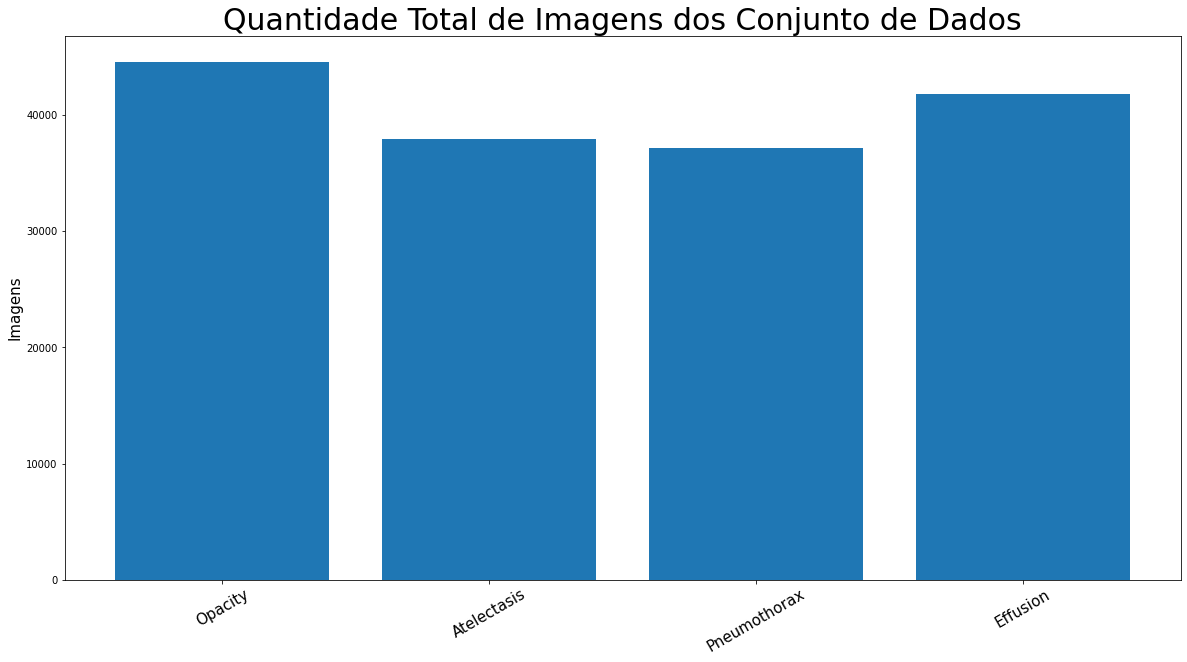

In [3]:
count_findings = list()
for finding in list(dataset.columns)[4:]:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(list(dataset.columns)[4:], count_findings)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

In [4]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [5]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['labels_ref'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

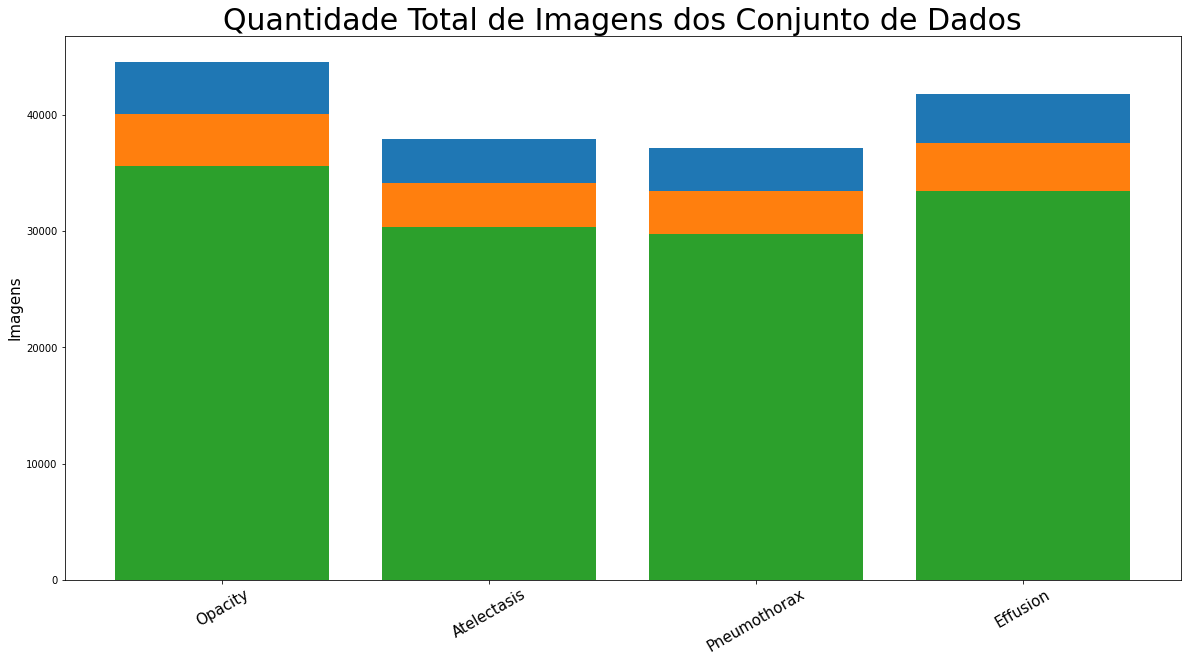

In [6]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val, count_test), 
                                          axis = 0))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val), axis = 0))
plt.bar(list(f_train.columns)[4:], count_train)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

### Keras Data Generator

In [7]:
image_size, batch_size = 256, 64
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

In [24]:
core_idg = ImageDataGenerator(rescale = 1/255., 
                              shear_range = 0.1, zoom_range = 0.15,
                              rotation_range = 5, width_shift_range = 0.1, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size), 
                                         shuffle = True)

core_idg = ImageDataGenerator(rescale = 1/255.)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size),
                                         shuffle = False)

test_gen = core_idg.flow_from_dataframe(dataframe = f_test, directory = None, 
                                        x_col = 'Path', y_col = labels, 
                                        class_mode = 'raw', batch_size = batch_size,
                                        target_size = (image_size, image_size),
                                        shuffle = False)

y_labels_valid = valid_gen.labels
y_labels_test = test_gen.labels

Found 70159 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


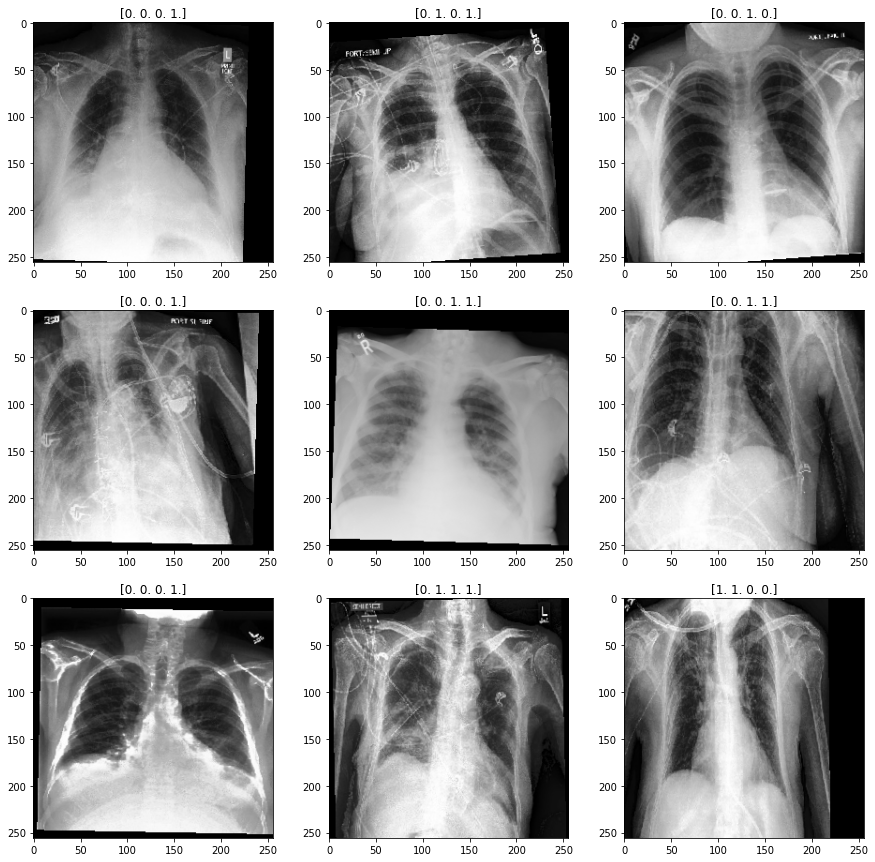

In [16]:
(x,y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

### Organizing a Callback Utility Function

In [ ]:
def get_callbacks(model_name, csv_filename, monitor = 'val_acc',):
    '''
    creates a list of useful callbacks for training the network

    Args:
        model_name (str) --> model name under review
        monitor (str) --> callback analysis metrics
        csv_filename (str) --> log csv file name

    Returns:
        callbacks (list) --> callback list
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    csv_logger = tf.keras.callbacks.CSVLogger(csv_filename, separator = ",", 
                                              append = False)
    
    return [checkpoint, csv_logger]

### Defining a Layer Freezing Method

In [ ]:
def freeze_layers(conv_base, layer_name):
  '''
  freeze layers of convolutional neural network training

  Args:
    conv_base (tensor) --> convolutional layers of the model
    layer_name (str) --> name of the freezing weight boundary layer
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### DenseNet121

In [ ]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', 
                         input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
densenet = tf.keras.Model(base_model.input, output)
densenet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('densenet', 'densenet.csv' ,'val_auc')

In [ ]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'conv3_block5_1_relu', 'conv4_block5_0_relu', 
               'conv4_block17_1_conv', 'conv5_block4_concat']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco conv3_block5_1_relu found!
Bloco conv4_block5_0_relu found!
Bloco conv4_block17_1_conv found!
Bloco conv5_block4_concat found!


In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[4])
densenet.summary()

In [ ]:
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5946 - auc: 0.7299
Epoch 1: val_auc improved from -inf to 0.63750, saving model to model.densenet.h5
1096/1096 [==============================] - 686s 606ms/step - loss: 0.5946 - auc: 0.7299 - val_loss: 1.1450 - val_auc: 0.6375
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5646 - auc: 0.7634
Epoch 2: val_auc improved from 0.63750 to 0.71216, saving model to model.densenet.h5
1096/1096 [==============================] - 652s 590ms/step - loss: 0.5646 - auc: 0.7634 - val_loss: 0.6294 - val_auc: 0.7122
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5499 - auc: 0.7781
Epoch 3: val_auc improved from 0.71216 to 0.76073, saving model to model.densenet.h5
1096/1096 [==============================] - 648s 586ms/step - loss: 0.5499 - auc: 0.7781 - val_loss: 0.5945 - val_auc: 0.7607
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5397 - auc: 0.7885

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet1')
!zip -r model_densenet1.zip /content/model_densenet1
shutil.move('/content/model_densenet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[3])
densenet.summary()

In [ ]:
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5301 - auc: 0.7976
Epoch 1: val_auc improved from 0.77979 to 0.78217, saving model to model.densenet.h5
1096/1096 [==============================] - 652s 590ms/step - loss: 0.5301 - auc: 0.7976 - val_loss: 0.5566 - val_auc: 0.7822
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5198 - auc: 0.8067
Epoch 2: val_auc did not improve from 0.78217
1096/1096 [==============================] - 653s 591ms/step - loss: 0.5198 - auc: 0.8067 - val_loss: 0.6750 - val_auc: 0.6888
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5118 - auc: 0.8137
Epoch 3: val_auc improved from 0.78217 to 0.78544, saving model to model.densenet.h5
1096/1096 [==============================] - 656s 593ms/step - loss: 0.5118 - auc: 0.8137 - val_loss: 0.5745 - val_auc: 0.7854
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4990 - auc: 0.8240
Epoch 4: val_auc did not improve fr

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet2')
!zip -r model_densenet2.zip /content/model_densenet2
shutil.move('/content/model_densenet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
densenet.summary()

In [ ]:
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4993 - auc: 0.8237
Epoch 1: val_auc improved from 0.78544 to 0.78637, saving model to model.densenet.h5
1096/1096 [==============================] - 653s 590ms/step - loss: 0.4993 - auc: 0.8237 - val_loss: 0.5777 - val_auc: 0.7864
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4896 - auc: 0.8314
Epoch 2: val_auc improved from 0.78637 to 0.79547, saving model to model.densenet.h5
1096/1096 [==============================] - 655s 593ms/step - loss: 0.4896 - auc: 0.8314 - val_loss: 0.5740 - val_auc: 0.7955
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4784 - auc: 0.8398
Epoch 3: val_auc improved from 0.79547 to 0.80637, saving model to model.densenet.h5
1096/1096 [==============================] - 657s 595ms/step - loss: 0.4784 - auc: 0.8398 - val_loss: 0.5386 - val_auc: 0.8064
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4654 - auc: 0.8

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet3')
!zip -r model_densenet3.zip /content/model_densenet3
shutil.move('/content/model_densenet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
densenet.summary()

In [ ]:
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4539 - auc: 0.8575
Epoch 1: val_auc improved from 0.81470 to 0.81484, saving model to model.densenet.h5
1096/1096 [==============================] - 654s 591ms/step - loss: 0.4539 - auc: 0.8575 - val_loss: 0.5275 - val_auc: 0.8148
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4404 - auc: 0.8664
Epoch 2: val_auc did not improve from 0.81484
1096/1096 [==============================] - 651s 588ms/step - loss: 0.4404 - auc: 0.8664 - val_loss: 0.5858 - val_auc: 0.8087
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4259 - auc: 0.8755
Epoch 3: val_auc improved from 0.81484 to 0.82592, saving model to model.densenet.h5
1096/1096 [==============================] - 655s 593ms/step - loss: 0.4259 - auc: 0.8755 - val_loss: 0.5332 - val_auc: 0.8259
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4092 - auc: 0.8857
Epoch 4: val_auc did not improve fr

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet4')
!zip -r model_densenet4.zip /content/model_densenet4
shutil.move('/content/model_densenet4.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
densenet.summary()

In [ ]:
densenet.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4075 - auc: 0.8868
Epoch 1: val_auc did not improve from 0.82592
1096/1096 [==============================] - 650s 587ms/step - loss: 0.4075 - auc: 0.8868 - val_loss: 0.5453 - val_auc: 0.8150
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3946 - auc: 0.8942
Epoch 2: val_auc did not improve from 0.82592
1096/1096 [==============================] - 652s 589ms/step - loss: 0.3946 - auc: 0.8942 - val_loss: 0.5496 - val_auc: 0.8211
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3786 - auc: 0.9029
Epoch 3: val_auc did not improve from 0.82592
1096/1096 [==============================] - 652s 589ms/step - loss: 0.3786 - auc: 0.9029 - val_loss: 0.5670 - val_auc: 0.8195
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3632 - auc: 0.9107
Epoch 4: val_auc improved from 0.82592 to 0.84443, saving model to model.densenet.h5
1096/1096 [=================

In [ ]:
densenet.load_weights('/content/model.densenet.h5')
densenet.save('model_densenet5')
!zip -r model_densenet5.zip /content/model_densenet5
shutil.move('/content/model_densenet5.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
shutil.move('/content/model.densenet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
csv_log1 = pd.read_csv('/content/densenet1.csv')
csv_log2 = pd.read_csv('/content/densenet2.csv')
csv_log3 = pd.read_csv('/content/densenet3.csv')
csv_log4 = pd.read_csv('/content/densenet4.csv')
csv_log5 = pd.read_csv('/content/densenet5.csv')

csv_log = pd.concat([csv_log1, csv_log2, csv_log3, 
                     csv_log4, csv_log5])

csv_log.reset_index(inplace = True)
csv_log.drop(['index', 'epoch'], axis = 1, inplace = True)
csv_log.to_csv(path_or_buf = 'densenet_log.csv', sep = ',')

shutil.move('/content/densenet_log.csv', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

### Evaluative Metrics of the Trained Model

In [18]:
def binarize_preds(pred_array, column, threshold):
  '''
  function that binarizes multi-label prediction labels from a threshold

  Args:
    pred_array (array) --> array with multi-label predictions
    column (int) --> column under analysis
    threshold (float) --> Binarization threshold for the column under analysis
  
  Returns:
    pred_bin (array) --> array with the binarized predictions of the column 
    under analysis
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

In [25]:
y_pred_val = densenet.predict(valid_gen)
y_pred = densenet.predict(test_gen)
print(f'AUC | Dados de Validação = {densenet.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {densenet.evaluate(test_gen)[1] * 100} %')

138/138 [==============================] - 76s 514ms/step - loss: 0.5055 - auc: 0.8444
AUC | Dados de Validação = 84.44288372993469 %
138/138 [==============================] - 71s 514ms/step - loss: 0.5002 - auc: 0.8468
AUC | Dados de Teste = 84.68393087387085 %


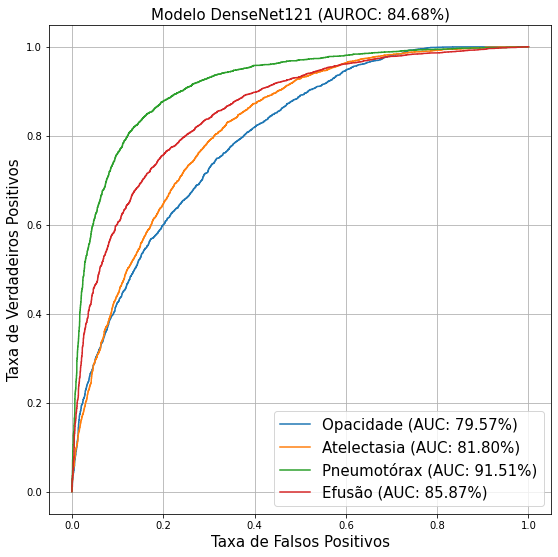

In [26]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [52]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    precision = matrix[0,0] / (matrix[0,0]+matrix[0,1])
    recall = matrix[0,0] / (matrix[0,0]+matrix[1,0])
    f1_score = (2 * precision*recall) / (precision + recall) 
    threshold_variation[label_index].append(f1_score)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [55]:
for label_index in range(0,4):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Opacidade== 
[[3600  712]
 [1994 2464]], Threshold = 50
Acurácia = 69.14481185860889 % | Precisão = 83.48794063079778 % | 
Sensibilidade = 64.35466571326421 % | F1 Score = 72.6832222895215 %

==Atelectasia== 
[[3991  979]
 [1366 2434]], Threshold = 64
Acurácia = 73.26111744583808 % | Precisão = 80.30181086519114 % | 
Sensibilidade = 74.50065335075602 % | F1 Score = 77.29253413382395 %

==Pneumotórax== 
[[4463  589]
 [ 779 2939]], Threshold = 47
Acurácia = 84.40136830102622 % | Precisão = 88.34125098970705 % | 
Sensibilidade = 85.13925982449447 % | F1 Score = 86.71070526520303 %

==Efusão== 
[[3908  682]
 [1289 2891]], Threshold = 67
Acurácia = 77.52565564424174 % | Precisão = 85.14161220043573 % | 
Sensibilidade = 75.1972291706754 % | F1 Score = 79.86104015530806 %

